# Tugas Praktikum Minggu 4
### Nicholas Juan Kalvin P. | 162012133068
<hr>



# Image Mining

## Tugas Praktikum:
<ol>
    <li> Download data teks dari halaman: <a>https://raw.githubusercontent.com/ruzcmc/medmon/main/jawapos19012021.csv</a>
    <li>Buatlah <i>wordcloud</i> dan <i> most common word barplot</i>, interpretasikan hasilnya!</li>
    <li>Lakukan <i>clustering</i> dengan menggunakan fitur TF-IDF</li>
    <li>Buat visualisasi clusternya dan lakukan interpretasi terhadap hasil tersebut!</li>
</ol>

<hr>


In [267]:
# Modules and Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
import re
import string
import nlp_id
import seaborn as sns

from nltk.probability import FreqDist
from collections.abc import Sequence

from nlp_id.stopword import StopWord
from nlp_id.lemmatizer import Lemmatizer 
from nlp_id.tokenizer import Tokenizer 

from wordcloud import WordCloud



Selain dari library yang biasa digunakan untuk melakukan data mining di Python, digunakan beberapa library baru yang bekerja spesifik untuk memproses teks. <code>re</code> atau <code>regular expression</code >adalah salah satu library Python yang paling dikenal, digunakan untuk berbagai macam prosesing teks dari mengurangi tanda baca hingga mengganti bagian dari kata. 

<code>nlp-id</code> adalah library NLP khusus untuk Bahasa Indonesia yang memiliki fitur untuk Stopwords, Lemmatizing, Tokenizing dan lain-lain.  <code>nlp-id</code> mirip seperti <code>Sastrawi</code>, tetapi dengan komunitas yang jauh lebih aktif, akan terdapat beberapa hal yang <code>nlp-id</code> dapat lakukan lebih baik dari <code>Sastrawi</code>

<code>Wordcloud</code> adalah library untuk membuat wordcloud

<hr>

## Step 1: Dataset Loading

In [268]:
df = pd.read_csv('text.csv')

df.drop(columns = ['Unnamed: 0', 'published', 'link'], inplace=True)
df.head(10)

,title,content,summary
0,Taiwan Batalkan Festival Besar Lampion,elasa membatalkan festival besar selama libura...,Taiwan pada Selasa membatalkan festival besar ...
1,"Sebut Bali Ramah LGBT, Kristeb Gray Ditangkap ...",h Hukum dan HAM Bali melakukan upaya hukum ter...,KANTOR Wilayah Hukum dan HAM Bali melakukan up...
2,Uji klinis Awal Sebut Vaksin Covid-19 Rusia 10...,"s kesehatan konsumen di Rusia, Rospotrebnadzor...","Badan pengawas kesehatan konsumen di Rusia, Ro..."
3,Masyarakat Harus Disiplin Terapkan Protokol Ke...,ologi Fakultas Kesehatan Masyarakat Universita...,PAKAR epidemiologi Fakultas Kesehatan Masyarak...
4,Belasan Motor Bodong dari Jawa Gagal Diselundu...,it sepeda motor bodong atau tanpa dilengkapi s...,SEKITAR 16 unit sepeda motor bodong atau tanpa...
5,Citilink Layani Penerbangan Padang-Medan Empat...,ar Udara Internasional Kualanamu (KNIA) di Del...,Otoritas Bandar Udara Internasional Kualanamu ...
6,40 Ton Beras Diangkut dari Sulteng dengan Tol ...,kut Logistik Tol Laut KM Kendhaga Nusantara 13...,Kapal pengangkut Logistik Tol Laut KM Kendhaga...
7,Kolaborasi KPK-BPN-PLN Riau Selamatkan Aset Ta...,"tara PT PLN (Persero), Komisi Pemberantasan Ko...","Kolaborasi antara PT PLN (Persero), Komisi Pem..."
8,Hukuman Jerinx Didiskon 4 Bulan dalam Putusan ...,de Ary Astina alias Jerinx mendapat keringanan...,TERDAKWA I Gede Ary Astina alias Jerinx mendap...
9,Kelebihan Listrik Sumsel Disalurkan untuk Jamb...,rgi listrik dari pembangkit listrik di wilayah...,Kelebihan energi listrik dari pembangkit listr...


Kolom published dan link saya hapus, karena tidak terdapat nilai yang berguna untuk melakukan prosesing teks

<hr>

## Step 2: Text Cleaning

Beberapa langkah pembersihan teks yang dilakukan pada dataset ini adalah:
<ul>
    <li>Mengubah menjadi huruf kecil</li>
    <li>Menghilangkan URL dan unsur HTML</li>
    <li>Menghilangkan Emoji dan Emoticons</li>
    <li>Menghilangkan tanda baca</li>
    <li>Menghilangkan <i>stopwords</i></li>
    <li>Lematisasi (PySastrawi)</li>
</ul>


### Lowercasing

In [269]:
for (column, textval) in df.iteritems():
    df[column] = df[column].str.lower()

df.head(5)

,title,content,summary
0,taiwan batalkan festival besar lampion,elasa membatalkan festival besar selama libura...,taiwan pada selasa membatalkan festival besar ...
1,"sebut bali ramah lgbt, kristeb gray ditangkap ...",h hukum dan ham bali melakukan upaya hukum ter...,kantor wilayah hukum dan ham bali melakukan up...
2,uji klinis awal sebut vaksin covid-19 rusia 10...,"s kesehatan konsumen di rusia, rospotrebnadzor...","badan pengawas kesehatan konsumen di rusia, ro..."
3,masyarakat harus disiplin terapkan protokol ke...,ologi fakultas kesehatan masyarakat universita...,pakar epidemiologi fakultas kesehatan masyarak...
4,belasan motor bodong dari jawa gagal diselundu...,it sepeda motor bodong atau tanpa dilengkapi s...,sekitar 16 unit sepeda motor bodong atau tanpa...


### Menghilangkan unsur URL/HTML

In [270]:
def bersih_text(text):
    text = str(text)
    text = re.sub("@[A-Za-z0-9_]+", "", text)  # Menghapus @<name> [mention twitter]
    text = re.sub("#\w+", "", text)
    text = re.sub("\[.*?\]", "", text)
    text = re.sub("https?://\S+|www\.\S+", "", text)
    text = re.sub("<.*?>+", "", text)
    text = re.sub("[%s]" % re.escape(string.punctuation), "", text)
    # text = re.sub('\n', '', text)
    text = re.sub("\w*\d\w*", "", text)
    text = re.sub("\d+", "", text)
    text = re.sub("\s+", " ", text).strip()
    # text = re.sub('\n', '', text) jadi:
    text = text.replace("\n", " ")
    text = " ".join(text.split())
    return text

for column, content in df.iteritems():
    for index, value in enumerate(df[column]):
        df[column][index] = bersih_text(df[column][index])

df_clean = df.copy()

### Tokenizing

In [271]:
tokenizer = Tokenizer() 

for column, content in df.iteritems():
    for index, value in enumerate(df[column]):
        df[column][index] = tokenizer.tokenize(df[column][index])

df_token = df.copy()


Tokenizing dilakukan untuk memisahkan setiap kata, yang lalu dapat dilakukan lematisasi

In [272]:
df.head(5)

,title,content,summary
0,"[taiwan, batalkan, festival, besar, lampion]","[elasa, membatalkan, festival, besar, selama, ...","[taiwan, pada, selasa, membatalkan, festival, ..."
1,"[sebut, bali, ramah, lgbt, kristeb, gray, dita...","[h, hukum, dan, ham, bali, melakukan, upaya, h...","[kantor, wilayah, hukum, dan, ham, bali, melak..."
2,"[uji, klinis, awal, sebut, vaksin, rusia, efek...","[s, kesehatan, konsumen, di, rusia, rospotrebn...","[badan, pengawas, kesehatan, konsumen, di, rus..."
3,"[masyarakat, harus, disiplin, terapkan, protok...","[ologi, fakultas, kesehatan, masyarakat, unive...","[pakar, epidemiologi, fakultas, kesehatan, mas..."
4,"[belasan, motor, bodong, dari, jawa, gagal, di...","[it, sepeda, motor, bodong, atau, tanpa, dilen...","[sekitar, unit, sepeda, motor, bodong, atau, t..."



### Lemmatizing

In [273]:
lemmatizer = Lemmatizer() 

for column, content in df.iteritems():
    for index, value in enumerate(df[column]):
        df[column][index] = [lemmatizer.lemmatize(word) for word in df[column][index]]



In [274]:
df.head(5)

,title,content,summary
0,"[taiwan, batal, festival, besar, lampion]","[elasa, batal, festival, besar, lama, libur, t...","[taiwan, pada, selasa, batal, festival, besar,..."
1,"[sebut, bal, ramah, lgbt, kristeb, gray, tangk...","[h, hukum, dan, ham, bal, laku, upaya, hukum, ...","[kantor, wilayah, hukum, dan, ham, bal, laku, ..."
2,"[uji, klinis, awal, sebut, vaksin, rusia, efek...","[s, sehat, konsumen, di, rusia, rospotrebnadzo...","[badan, awas, sehat, konsumen, di, rusia, rosp..."
3,"[masyarakat, harus, disiplin, terap, protokol,...","[ologi, fakultas, sehat, masyarakat, universit...","[pakar, epidemiologi, fakultas, sehat, masyara..."
4,"[belas, motor, bodong, dari, jawa, gagal, selu...","[it, sepeda, motor, bodong, atau, tanpa, lengk...","[sekitar, unit, sepeda, motor, bodong, atau, t..."


Lematisasi memberikan output dataframe dimana isinya telah diambil kata akarnya.

### Menghilangkan Stopwords

In [275]:
stopword = StopWord() 

all_content = []
for index, cvalue in enumerate(df['content']):
    all_content = all_content + cvalue
 
all_summary = []
for index, svalue in enumerate(df['summary']):
    all_summary = all_summary + svalue   
        
all_title = []
for index, tvalue in enumerate(df['title']):
    all_title = all_title + tvalue 

all_content_str = stopword.remove_stopword(' '.join(all_content))
all_summary_str = stopword.remove_stopword(' '.join(all_summary))
all_title_str = stopword.remove_stopword(' '.join(all_title))

<hr>

## Step 3: Wordcloud dan Histogram

### Worcloud dari kolom konten

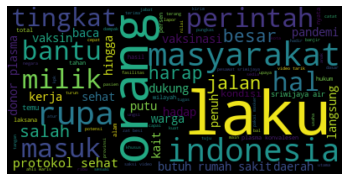

In [276]:
wc = WordCloud(max_words=5000, margin=2).generate(all_content_str)

plt.axis("off")
plt.imshow(wc, interpolation='bilinear')
plt.show()

### Worcloud dari kolom summary

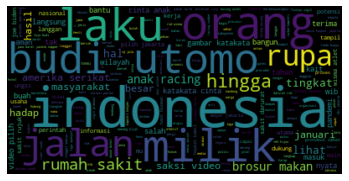

In [277]:
wc = WordCloud(max_words=5000, margin=2).generate(all_summary_str)

plt.axis("off")
plt.imshow(wc, interpolation='bilinear')
plt.show()

### Worcloud dari kolom title

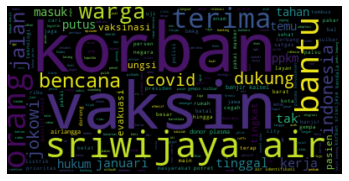

In [278]:
wc = WordCloud(max_words=5000, margin=2).generate(all_title_str)

plt.axis("off")
plt.imshow(wc, interpolation='bilinear')
plt.show()

In [279]:
cfdist = FreqDist(all_content_str.split(sep=' '))
sfdist = FreqDist(all_summary_str.split(sep=' '))
tfdist = FreqDist(all_title_str.split(sep=' '))



In [280]:
most_common_cfdist = cfdist.most_common(20)
most_common_sfdist = sfdist.most_common(20)
most_common_tfdist = tfdist.most_common(20)

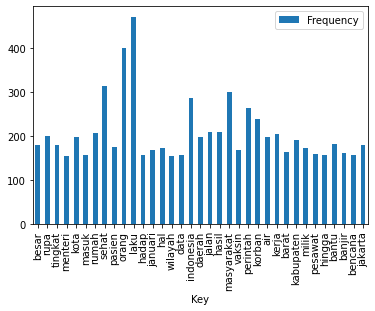

In [281]:
df_freq_token_content = pd.DataFrame.from_dict(cfdist, orient='index')
df_freq_token_content.columns = ['Frequency']
df_freq_token_content.index.name = 'Key'

plt_df_freq_token_content = df_freq_token_content[df_freq_token_content['Frequency'] > 150]
plt_df_freq_token_content.plot(kind='bar')
plt.show()


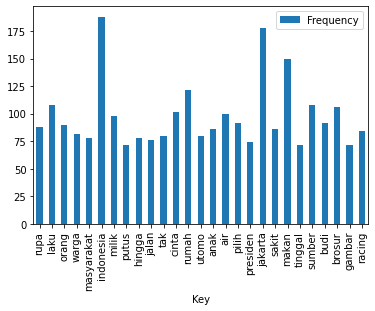

In [282]:
df_freq_token_summary = pd.DataFrame.from_dict(sfdist, orient='index')
df_freq_token_summary.columns = ['Frequency']
df_freq_token_summary.index.name = 'Key'

plt_df_freq_token_summary = df_freq_token_summary[df_freq_token_summary['Frequency'] > 70]
plt_df_freq_token_summary.plot(kind='bar')
plt.show()

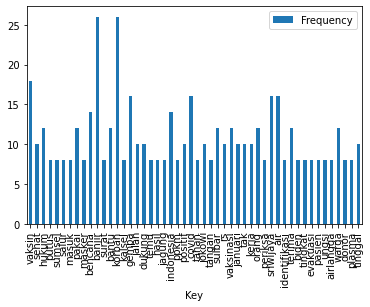

In [283]:
df_freq_token_title = pd.DataFrame.from_dict(tfdist, orient='index')
df_freq_token_title.columns = ['Frequency']
df_freq_token_title.index.name = 'Key'

plt_df_freq_token_title = df_freq_token_title[df_freq_token_title['Frequency'] > 7]
plt_df_freq_token_title.plot(kind='bar')
plt.show()

<hr>

## Step 4: TF-IDF Clustering

In [284]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [285]:
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
X = vectorizer.fit_transform(df_clean['content'] + df_clean['summary'] + df_clean['title'])
# X = vectorizer.fit_transform(df['content'][0])
tfidf_tokens = vectorizer.get_feature_names()

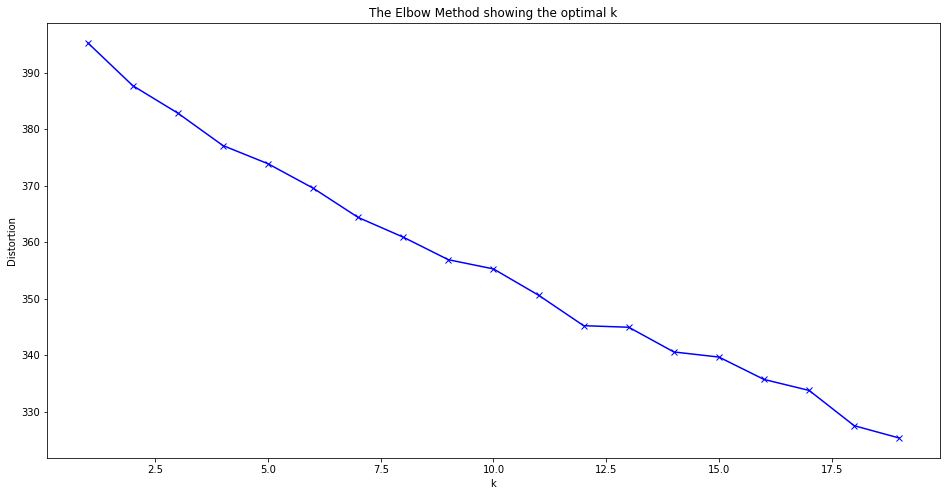

In [286]:
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()
clusters = kmeanModel.labels_


Blok kode ini digunakan untuk melakukan cluster sebanyak 20 kali, untuk mendapatkan plot elbow yang akurat

In [287]:

kmeanModel = KMeans(n_clusters=3)
kmeanModel.fit(X)
clusters = kmeanModel.labels_



Digunakan nilai cluster bernilai 3 yang diketahui dari plot elbow

In [288]:

pca = PCA(n_components=2, random_state=42)
pca_vecs = pca.fit_transform(X.toarray())
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]

# assign clusters and PCA vectors to columns in the original dataframe
df['cluster'] = clusters
df['x0'] = x0
df['x1'] = x1





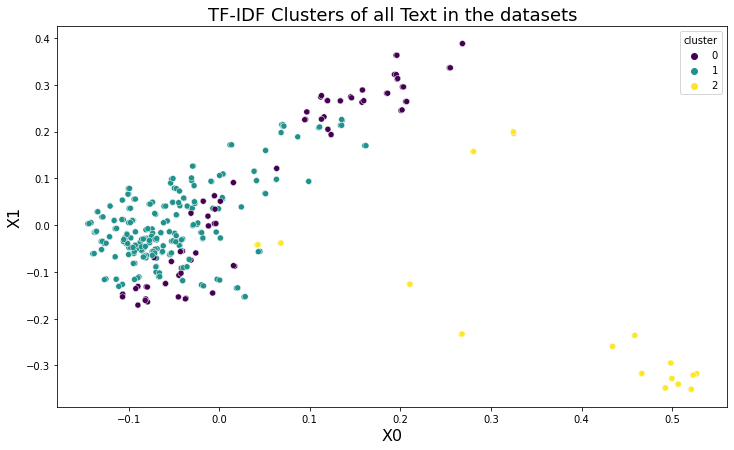

In [289]:

plt.figure(figsize=(12, 7))
plt.title("TF-IDF Clusters of all Text in the datasets", fontdict={"fontsize": 18})
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
sns.scatterplot(data=df, x='x0', y='x1', hue='cluster', palette="viridis")
plt.show()

Dari scatterplot diatas, diketahui benar adanya bahwa tiga cluster adalah nilai yang cukup untuk mewakkili dataset ini, dilihat dari titik-titiknya yang memiliki batasan jelas.

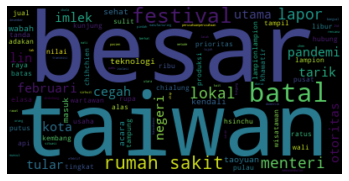

In [290]:
cluster0 = df.loc[pd.Index([0], name="cluster")]
wc = WordCloud(max_words=5000, margin=2).generate(stopword.remove_stopword(' '.join(cluster0['content'][0])))

plt.axis("off")
plt.imshow(wc, interpolation='bilinear')
plt.show()

Menurut wordcloud yang dibuat berdasarkan cluster, cluster0 berisi semua kata yang memiliki hubungan dengan Covid-19
### Taiwan, Festival, COVID

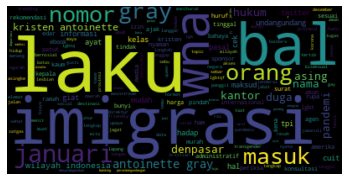

In [291]:
cluster0 = df.loc[pd.Index([1], name="cluster")]
wc = WordCloud(max_words=5000, margin=2).generate(stopword.remove_stopword(' '.join(cluster0['content'][1])))

plt.axis("off")
plt.imshow(wc, interpolation='bilinear')
plt.show()

Sedangkan, cluster 1 berisi semua teks yang berhubungan dengan imigrasi, wna, dan kecelakaan
### Imigrasi, Kecelakaan, WNA

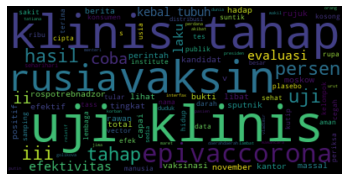

In [292]:
cluster0 = df.loc[pd.Index([2], name="cluster")]
wc = WordCloud(max_words=5000, margin=2).generate(stopword.remove_stopword(' '.join(cluster0['content'][2])))

plt.axis("off")
plt.imshow(wc, interpolation='bilinear')
plt.show()

Cluster terakhir yaitu cluster 2 berisi semua berita yang berhubungan juga dengan Covid, lebih spesifiknya adalah perkembangan vaksin covid 
### Vaksin, Uji Klinis, Rusia
